In [ ]:
!pip install implicit==0.4.4 lightgbm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [2]:
data = pd.read_csv('..\webinar_2\\retail_train.csv')
item_features = pd.read_csv('..\webinar_2\\product.csv')
user_features = pd.read_csv('..\webinar_2\\hh_demographic.csv')

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [9]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

c:\Users\Home\geekbrains\recomend_sys\webinar_6\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


In [10]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


In [11]:
recommender = MainRecommender(data_train_matcher)

100%|██████████| 5001/5001 [00:00<00:00, 27471.99it/s]


In [12]:
ACTUAL_COL = 'actual'

In [13]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [14]:
def evalRecall(df_result, target_col_name, recommend_model, N):
    result_col_name = str(recommend_model.__name__).split('get_')[1]+ '_' + str(N)
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [15]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [16]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [17]:
TOPK_RECALL = 50
TOPK_PRECISION = 5

N_PREDICT = 50 

In [18]:
for model in (recommender.get_own_recommendations, recommender.get_similar_items_recommendation, recommender.get_als_recommendations):
    evalRecall(result_eval_matcher, USER_COL,  model, N=50)

In [19]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_recommendations_50', 0.06525657038145165),
 ('als_recommendations_50', 0.04856910488929621),
 ('similar_items_recommendation_50', 0.03310464259345422)]

In [20]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_recommendations_50', 0.17712691771269176),
 ('als_recommendations_50', 0.11985123198512321),
 ('similar_items_recommendation_50', 0.0609948860994886)]

In [21]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [22]:
for N_PREDICT in [10, 20, 50, 100, 200, 500]:
    evalRecall(result_eval_matcher, USER_COL,  recommender.get_own_recommendations, N=N_PREDICT)

In [23]:
result = {}
for col_name in result_eval_matcher.columns[2:]:
    top_k = int(col_name.split('_')[2])
    result[top_k] = result_eval_matcher.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

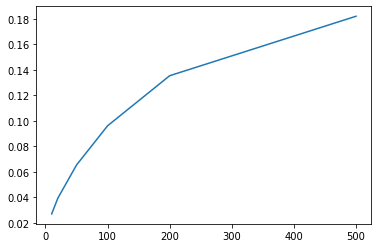

In [24]:
result = pd.DataFrame.from_dict(result, orient='index')
plt.plot(result.index, result[0])

In [25]:
N_PREDICT = 200

In [26]:
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [27]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [28]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [29]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [30]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


In [31]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [32]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [33]:
df_ranker_train.target.value_counts()

0.0    397661
1.0     17984
Name: target, dtype: int64

Задание 2

In [34]:
#Частотность покупок раз/месяц
data_weeks = data.groupby(['user_id', 'week_no'])[['basket_id']].count().rename(columns={'basket_id': 'count_items'}).reset_index()
data_weeks['month'] = data_weeks['week_no'] // 4

In [35]:
purchases_per_month = data_weeks.groupby(['user_id', 'month'])[['count_items']].count().groupby('user_id')[['count_items']].mean().rename(columns={'count_items': 'purchases_per_month'})
user_features = user_features.merge(purchases_per_month, on='user_id', how='left')

In [36]:
# сумма корзины
basket_sum_price = data.groupby('basket_id')[['sales_value']].sum().rename(columns={'sales_value': 'basket_sum'})
data = data.merge(basket_sum_price, on='basket_id', how='left')

In [37]:
# средняя стоимость корзины
avg_basket = data.groupby('user_id')[['basket_sum']].mean().rename(columns={'basket_sum': 'basket_avg'})
user_features = user_features.merge(avg_basket, on='user_id', how='left')

In [38]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [39]:
#средняя цена товара
item_max_prices = data.groupby('item_id')[['sales_value']].max().rename(columns={'sales_value': 'price'})
item_features = item_features.merge(item_max_prices, on='item_id', how='left')

In [40]:
#средняя цена по категории
category_mean_price = item_features.groupby('commodity_desc')[['price']].mean().rename(columns={'price': 'cat_mean_price'})
item_features = item_features.merge(category_mean_price, on='commodity_desc', how='left')

In [41]:
# разница в цене и средней цене по категории
item_features['diff_price'] = item_features['cat_mean_price'] - item_features['price']

In [42]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,price,...,diff_price,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,purchases_per_month,basket_avg
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,15.96,...,-9.261571,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.904762,81.857839
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,23.98,...,-9.525100,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.904762,81.857839


In [43]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [44]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'price',
 'cat_mean_price',
 'diff_price',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'purchases_per_month',
 'basket_avg']

Обучение модели ранжирования

In [45]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=12,
                     n_estimators=500,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

c:\Users\Home\geekbrains\recomend_sys\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Home\geekbrains\recomend_sys\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Home\geekbrains\recomend_sys\env\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [46]:
df_ranker_predict = df_ranker_train.copy()

In [47]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

Evaluation on test dataset

In [48]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [49]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: total: 8.38 s
Wall time: 8.47 s


In [50]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.14441176470588235)]

In [51]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [52]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [53]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1807832898172324)
('own_rec', 0.14441176470588235)


c:\Users\Home\geekbrains\recomend_sys\webinar_6\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)
